In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from classes import CustomLogisticRegression, LossTracker
from helpers import evaluate_model, load_data

from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    classification_report,
    log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

import pickle

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

seed = 777

In [2]:
import pickle

(train_X_folds, train_y_folds, test_X_folds, test_y_folds, feature_names_folds, reverse_map_folds) = pickle.load(open('data/prepared_data.pkl', 'rb'))

In [3]:
train_X = train_X_folds[0]
train_y = train_y_folds[0]
test_X = test_X_folds[0]
test_y = test_y_folds[0]
feature_names = feature_names_folds[0]
reverse_map = reverse_map_folds[0]

In [4]:
print("=== BASELINE MODEL EVALUATION ===")

# Create model with specific parameters
alpha = 5
l1_ratio = 0.75

print(f"Training model with α={alpha}, L1 ratio={l1_ratio} (Elastic Net)...")

tracker = LossTracker(train_X, train_y, test_X, test_y)

result = evaluate_model(
    lambda: CustomLogisticRegression(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=200,
        tol=1e-6,
        class_weight="balanced",
        random_state=seed,
        callback=tracker.create_callback(alpha, l1_ratio)
    ),
    train_X,
    train_y,
    test_X,
    test_y,
    get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
)

print(f"✅ Model trained successfully!")
print(f"   Iterations: {result['model'].n_iter_}")
print(f"   Time: {result['training_time']:.2f}s")

=== BASELINE MODEL EVALUATION ===
Training model with α=5, L1 ratio=0.75 (Elastic Net)...
✅ Model trained successfully!
   Iterations: 97
   Time: 14.49s



📈 LOSS CURVE ANALYSIS:


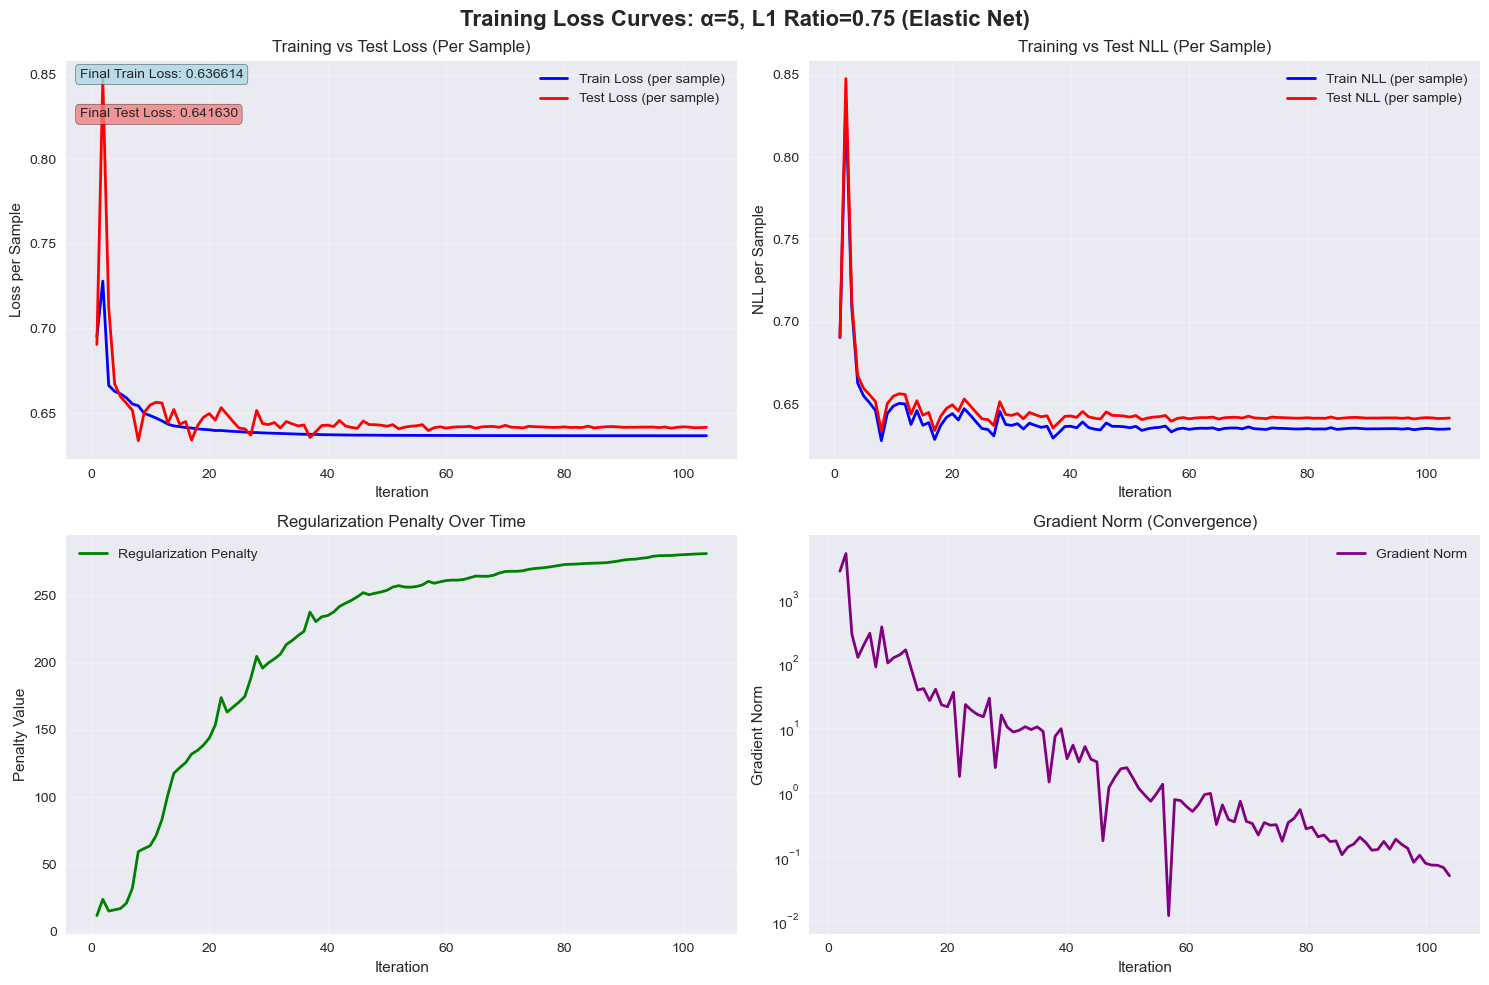

📊 LOSS ANALYSIS SUMMARY:
   Dataset sizes: Train=81,332, Test=20,434
   Initial Train Loss (per sample): 0.695073
   Final Train Loss (per sample): 0.636614
   Initial Test Loss (per sample): 0.690576
   Final Test Loss (per sample): 0.641630
   Train Loss Reduction: 0.058458
   Test Loss Reduction: 0.048947
   True Overfitting Gap (per sample): -0.005015
   Overfitting Ratio: -0.78%
   Final Regularization Penalty (per sample): 0.003454
   Regularization Ratio: 0.54%
   Final Gradient Norm: 0.050814
   Convergence Status: Not Converged

🔍 OVERFITTING ANALYSIS:
   Model shows overfitting: Test loss 0.79% higher than train loss
   Recent Train Improvement (last 5 iter): 0.267154
   Recent Test Improvement (last 5 iter): 5.150946


In [5]:
print("\n📈 LOSS CURVE ANALYSIS:")
print("=" * 50)

# Create loss curve plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Loss Curves: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. Training vs Test Loss (per sample)
ax1 = axes[0, 0]
if tracker.train_loss_history and tracker.test_loss_history:
    # Use the new convenience method
    per_sample_data = tracker.get_per_sample_losses()
    iterations = per_sample_data['iterations']
    train_loss_per_sample = per_sample_data['train_loss_per_sample']
    test_loss_per_sample = per_sample_data['test_loss_per_sample']
    
    ax1.plot(iterations, train_loss_per_sample, 'b-', label='Train Loss (per sample)', linewidth=2)
    ax1.plot(iterations, test_loss_per_sample, 'r-', label='Test Loss (per sample)', linewidth=2)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss per Sample')
    ax1.set_title('Training vs Test Loss (Per Sample)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add final values as text
    ax1.text(0.02, 0.98, f'Final Train Loss: {train_loss_per_sample[-1]:.6f}', 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax1.text(0.02, 0.88, f'Final Test Loss: {test_loss_per_sample[-1]:.6f}', 
             transform=ax1.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

# 2. Training vs Test NLL (Negative Log-Likelihood) per sample
ax2 = axes[0, 1]
if tracker.train_nll_history and tracker.test_nll_history:
    train_nll_per_sample = per_sample_data['train_nll_per_sample']
    test_nll_per_sample = per_sample_data['test_nll_per_sample']
    
    ax2.plot(iterations, train_nll_per_sample, 'b-', label='Train NLL (per sample)', linewidth=2)
    ax2.plot(iterations, test_nll_per_sample, 'r-', label='Test NLL (per sample)', linewidth=2)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('NLL per Sample')
    ax2.set_title('Training vs Test NLL (Per Sample)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

# 3. Regularization Penalty
ax3 = axes[1, 0]
if tracker.penalty_history:
    ax3.plot(iterations, tracker.penalty_history, 'g-', label='Regularization Penalty', linewidth=2)
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Penalty Value')
    ax3.set_title('Regularization Penalty Over Time')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Gradient Norm (Convergence)
ax4 = axes[1, 1]
if tracker.gradient_norm_history:
    ax4.plot(iterations[1:], tracker.gradient_norm_history[1:], 'purple', label='Gradient Norm', linewidth=2)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Gradient Norm')
    ax4.set_title('Gradient Norm (Convergence)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

# Print loss analysis summary
if tracker.train_loss_history and tracker.test_loss_history:
    # Use the new convenience methods
    per_sample_data = tracker.get_per_sample_losses()
    overfitting_metrics = tracker.get_overfitting_metrics()
    
    n_train = len(train_y)
    n_test = len(test_y)
    
    print(f"📊 LOSS ANALYSIS SUMMARY:")
    print(f"   Dataset sizes: Train={n_train:,}, Test={n_test:,}")
    print(f"   Initial Train Loss (per sample): {per_sample_data['train_loss_per_sample'][0]:.6f}")
    print(f"   Final Train Loss (per sample): {overfitting_metrics['final_train_loss_per_sample']:.6f}")
    print(f"   Initial Test Loss (per sample): {per_sample_data['test_loss_per_sample'][0]:.6f}")
    print(f"   Final Test Loss (per sample): {overfitting_metrics['final_test_loss_per_sample']:.6f}")
    print(f"   Train Loss Reduction: {per_sample_data['train_loss_per_sample'][0] - overfitting_metrics['final_train_loss_per_sample']:.6f}")
    print(f"   Test Loss Reduction: {per_sample_data['test_loss_per_sample'][0] - overfitting_metrics['final_test_loss_per_sample']:.6f}")
    print(f"   True Overfitting Gap (per sample): {overfitting_metrics['overfitting_gap']:.6f}")
    print(f"   Overfitting Ratio: {overfitting_metrics['overfitting_ratio_percent']:.2f}%")
    
    if tracker.penalty_history:
        penalty_per_sample = per_sample_data['penalty_per_sample'][-1]
        print(f"   Final Regularization Penalty (per sample): {penalty_per_sample:.6f}")
        print(f"   Regularization Ratio: {penalty_per_sample / overfitting_metrics['final_train_loss_per_sample'] * 100:.2f}%")
    
    if tracker.gradient_norm_history:
        print(f"   Final Gradient Norm: {tracker.gradient_norm_history[-1]:.6f}")
        print(f"   Convergence Status: {'Converged' if tracker.gradient_norm_history[-1] < 1e-4 else 'Not Converged'}")
        
    # Additional overfitting analysis
    print(f"\n🔍 OVERFITTING ANALYSIS:")
    if overfitting_metrics['is_overfitting']:
        overfitting_severity = (overfitting_metrics['final_test_loss_per_sample'] - overfitting_metrics['final_train_loss_per_sample']) / overfitting_metrics['final_train_loss_per_sample'] * 100
        print(f"   Model shows overfitting: Test loss {overfitting_severity:.2f}% higher than train loss")
    else:
        print(f"   Model shows good generalization: Test loss lower than train loss")
        
    # Convergence analysis
    if len(tracker.train_loss_history) > 5:
        recent_train_improvement = tracker.train_loss_history[-5] - tracker.train_loss_history[-1]
        recent_test_improvement = tracker.test_loss_history[-5] - tracker.test_loss_history[-1]
        print(f"   Recent Train Improvement (last 5 iter): {recent_train_improvement:.6f}")
        print(f"   Recent Test Improvement (last 5 iter): {recent_test_improvement:.6f}")
        
        if recent_train_improvement < 1e-6 and recent_test_improvement < 1e-6:
            print(f"   ✅ Model has converged (minimal recent improvement)")
        elif recent_train_improvement > recent_test_improvement * 2:
            print(f"   ⚠️  Potential overfitting (train improving faster than test)")
else:
    print("⚠️  No loss history available from tracker")

📊 MODEL PERFORMANCE METRICS:
Metric               Train      Test      
----------------------------------------
Accuracy             0.6626     0.6567    
Precision            0.1860     0.1811    
Recall               0.6035     0.5725    
F1-Score             0.2843     0.2751    

AUC                  0.6920     0.6709    
AUC-PR               0.2217     0.2148    

🔍 CONFUSION MATRICES:
Train Confusion Matrix:
TN: 48439      FP: 23861     
FN: 3581       TP: 5451      
Test Confusion Matrix:
TN: 12089      FP: 6020      
FN: 994        TP: 1331      


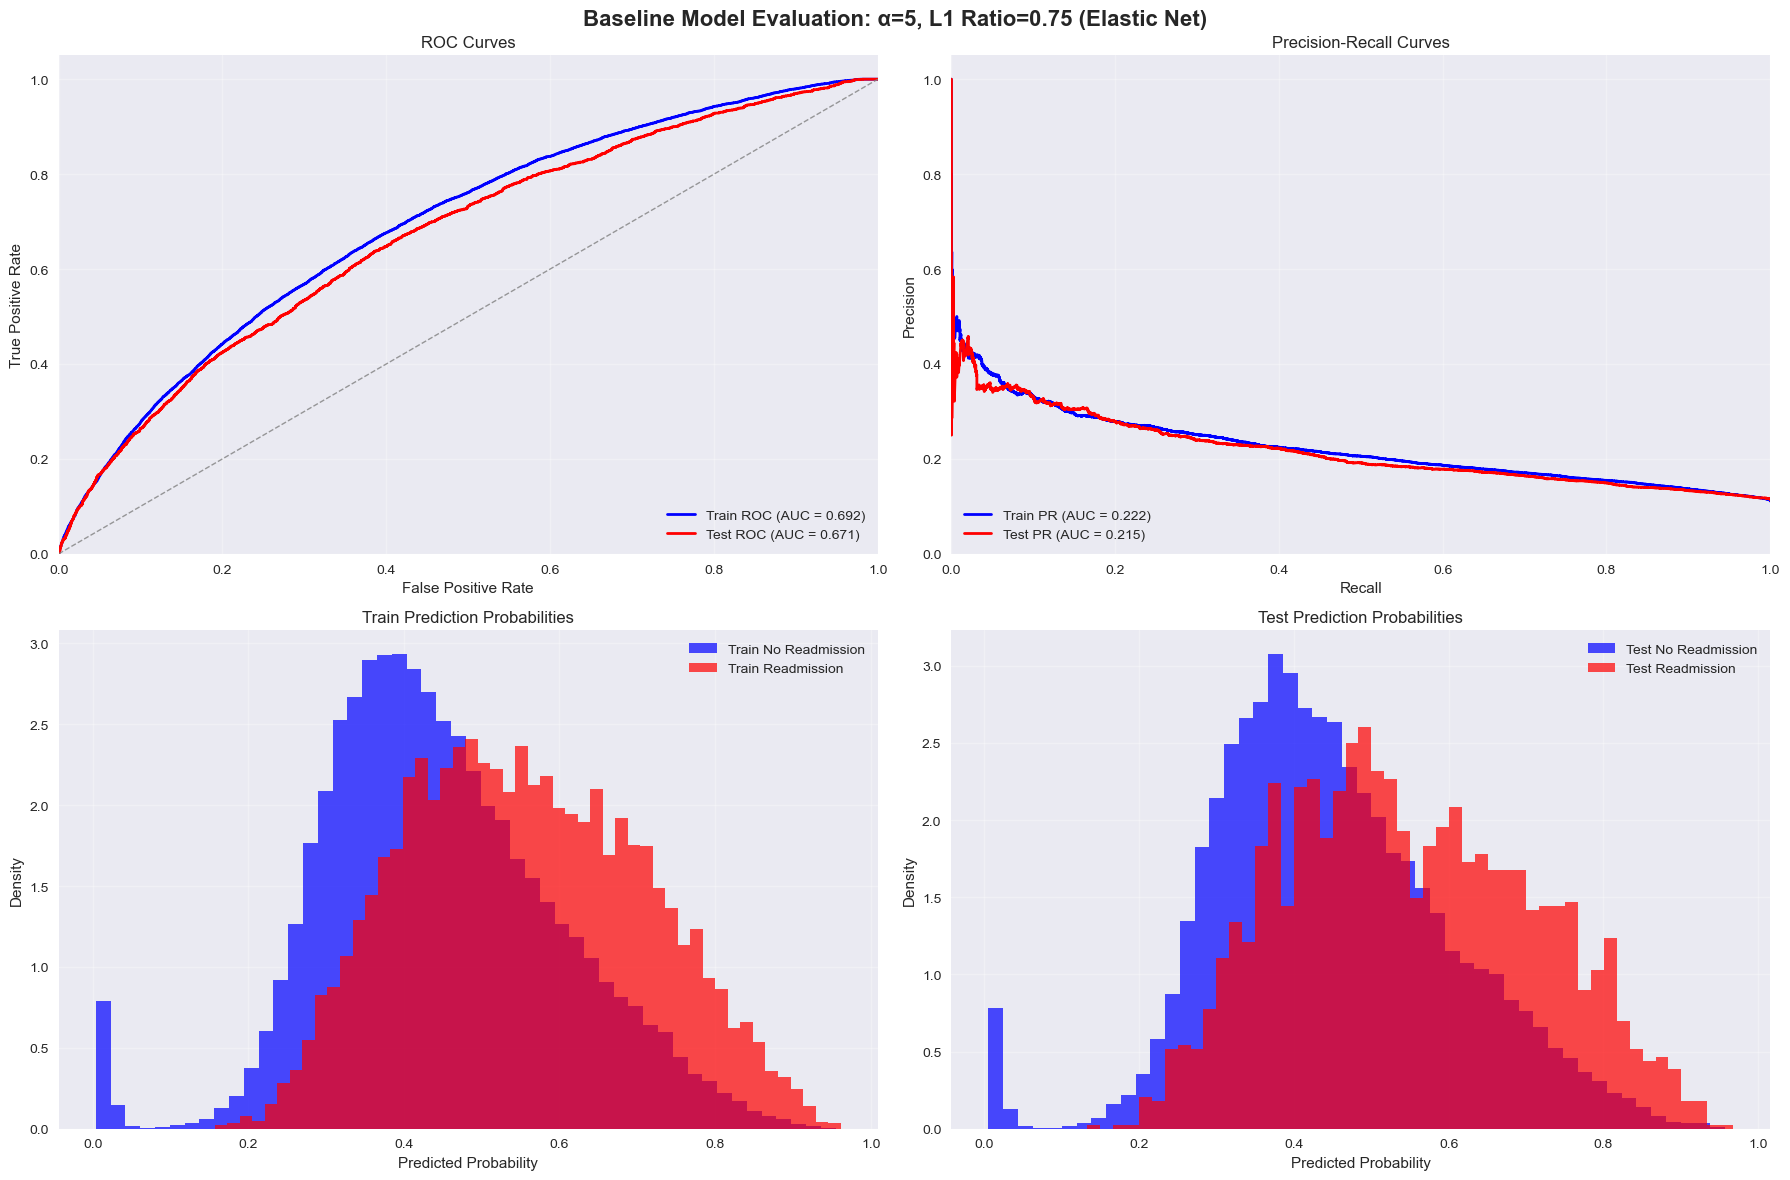


📋 CLASSIFICATION REPORTS:

Train Classification Report:
                precision    recall  f1-score   support

No Readmission       0.93      0.67      0.78     72300
   Readmission       0.19      0.60      0.28      9032

      accuracy                           0.66     81332
     macro avg       0.56      0.64      0.53     81332
  weighted avg       0.85      0.66      0.72     81332


Test Classification Report:
                precision    recall  f1-score   support

No Readmission       0.92      0.67      0.78     18109
   Readmission       0.18      0.57      0.28      2325

      accuracy                           0.66     20434
     macro avg       0.55      0.62      0.53     20434
  weighted avg       0.84      0.66      0.72     20434



In [6]:
# Get predictions and metrics
train_pred, test_pred = result['train_pred'], result['test_pred']
train_accuracy, test_accuracy, train_precision_score, test_precision_score, train_recall_score, test_recall_score, train_f1, test_f1 = result['train_accuracy'], result['test_accuracy'], result['train_precision_score'], result['test_precision_score'], result['train_recall_score'], result['test_recall_score'], result['train_f1'], result['test_f1']
train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc = result['train_roc_auc'], result['test_roc_auc'], result['train_pr_auc'], result['test_pr_auc']
train_cm, test_cm = result['train_cm'], result['test_cm']

# Print evaluation metrics
print(f"📊 MODEL PERFORMANCE METRICS:")
print(f"{'Metric':<20} {'Train':<10} {'Test':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {train_accuracy:<10.4f} {test_accuracy:<10.4f}")
print(f"{'Precision':<20} {train_precision_score:<10.4f} {test_precision_score:<10.4f}")
print(f"{'Recall':<20} {train_recall_score:<10.4f} {test_recall_score:<10.4f}")
print(f"{'F1-Score':<20} {train_f1:<10.4f} {test_f1:<10.4f}")
print(f"\n{'AUC':<20} {train_roc_auc:<10.4f} {test_roc_auc:<10.4f}")
print(f"{'AUC-PR':<20} {train_pr_auc:<10.4f} {test_pr_auc:<10.4f}")

print(f"\n🔍 CONFUSION MATRICES:")
print(f"Train Confusion Matrix:")
print(f"TN: {train_cm[0,0]:<10} FP: {train_cm[0,1]:<10}")
print(f"FN: {train_cm[1,0]:<10} TP: {train_cm[1,1]:<10}")
print(f"Test Confusion Matrix:")
print(f"TN: {test_cm[0,0]:<10} FP: {test_cm[0,1]:<10}")
print(f"FN: {test_cm[1,0]:<10} TP: {test_cm[1,1]:<10}")

train_fpr, train_tpr = result['train_roc_curve']
test_fpr, test_tpr = result['test_roc_curve']
train_precision, train_recall = result['train_pr_curve']
test_precision, test_recall = result['test_pr_curve']
train_pred_proba, test_pred_proba = result['train_decision_score'], result['test_decision_score']

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Baseline Model Evaluation: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(train_fpr, train_tpr, color='blue', lw=2, label=f'Train ROC (AUC = {train_roc_auc:.3f})')
ax1.plot(test_fpr, test_tpr, color='red', lw=2, label=f'Test ROC (AUC = {test_roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
ax2.plot(train_recall, train_precision, color='blue', lw=2, label=f'Train PR (AUC = {train_pr_auc:.3f})')
ax2.plot(test_recall, test_precision, color='red', lw=2, label=f'Test PR (AUC = {test_pr_auc:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distributions
ax3 = axes[1, 0]
ax3.hist(train_pred_proba[train_y == 0], bins=50, alpha=0.7, label='Train No Readmission', color='blue', density=True)
ax3.hist(train_pred_proba[train_y == 1], bins=50, alpha=0.7, label='Train Readmission', color='red', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Train Prediction Probabilities')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Prediction Probability Distributions
ax4 = axes[1, 1]
ax4.hist(test_pred_proba[test_y == 0], bins=50, alpha=0.7, label='Test No Readmission', color='blue', density=True)
ax4.hist(test_pred_proba[test_y == 1], bins=50, alpha=0.7, label='Test Readmission', color='red', density=True)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Test Prediction Probabilities')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\nTrain Classification Report:")
print(classification_report(train_y, train_pred, target_names=['No Readmission', 'Readmission']))

print(f"\nTest Classification Report:")
print(classification_report(test_y, test_pred, target_names=['No Readmission', 'Readmission']))


=== WITHOUT CLASS BALANCING ===
Training model with α=5, L1 ratio=0.75 (Elastic Net)...
✅ Model trained successfully!
   Iterations: 97
   Time: 14.49s
📊 MODEL PERFORMANCE METRICS:
Metric               Train      Test      
----------------------------------------
Accuracy             0.8890     0.8860    
Precision            0.5091     0.4565    
Recall               0.0062     0.0090    
F1-Score             0.0123     0.0177    

AUC                  0.6881     0.6701    
AUC-PR               0.2230     0.2155    

🔍 CONFUSION MATRICES:
Train Confusion Matrix:
TN: 72246      FP: 54        
FN: 8976       TP: 56        
Test Confusion Matrix:
TN: 18084      FP: 25        
FN: 2304       TP: 21        


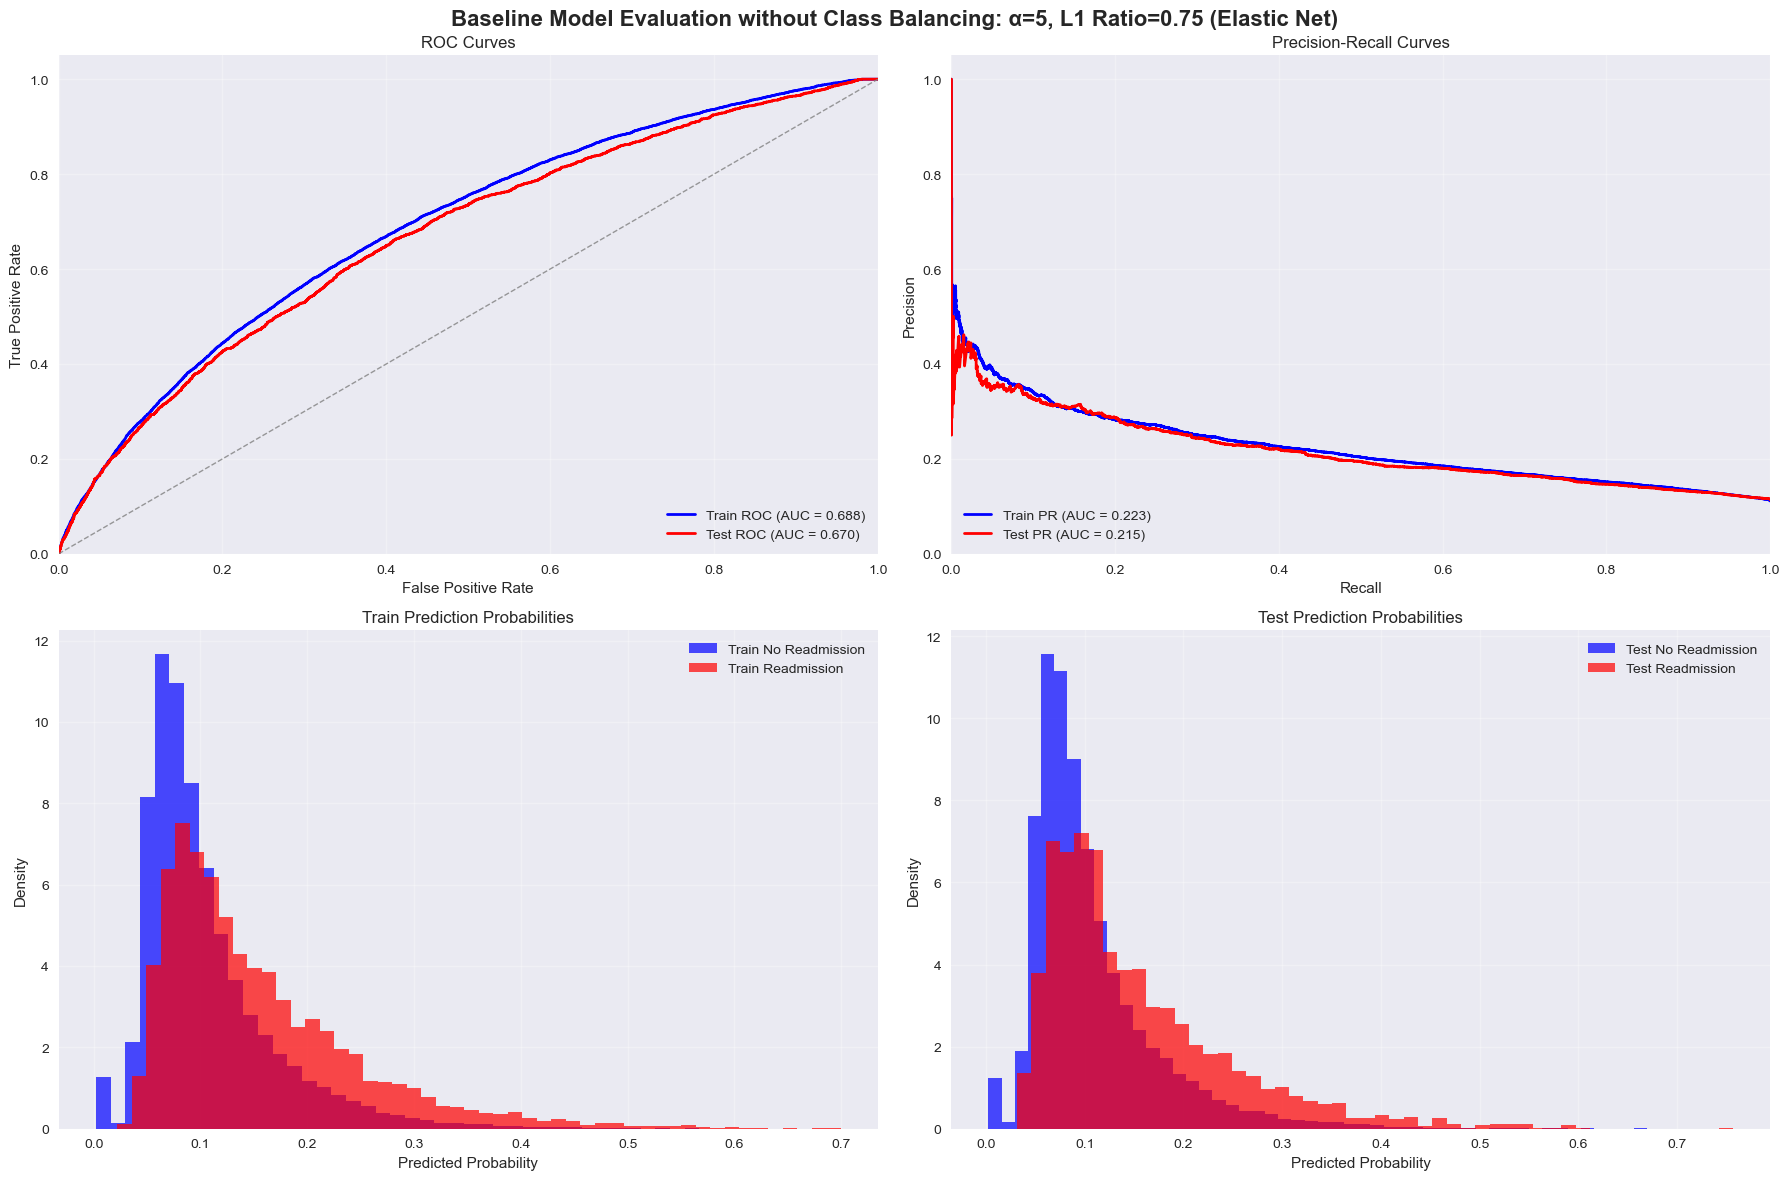


📋 CLASSIFICATION REPORTS:

Train Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      1.00      0.94     72300
   Readmission       0.51      0.01      0.01      9032

      accuracy                           0.89     81332
     macro avg       0.70      0.50      0.48     81332
  weighted avg       0.85      0.89      0.84     81332


Test Classification Report:
                precision    recall  f1-score   support

No Readmission       0.89      1.00      0.94     18109
   Readmission       0.46      0.01      0.02      2325

      accuracy                           0.89     20434
     macro avg       0.67      0.50      0.48     20434
  weighted avg       0.84      0.89      0.83     20434



In [7]:
print("=== WITHOUT CLASS BALANCING ===")

# Create model with specific parameters
alpha = 5
l1_ratio = 0.75

print(f"Training model with α={alpha}, L1 ratio={l1_ratio} (Elastic Net)...")

result_wo = evaluate_model(
    lambda: CustomLogisticRegression(
        alpha=alpha,
        l1_ratio=l1_ratio,
        max_iter=200,
        tol=1e-6,
        random_state=seed,
        callback=tracker.create_callback(alpha, l1_ratio)
    ),
    train_X,
    train_y,
    test_X,
    test_y,
    get_decision_score=lambda model, X: model.predict_proba(X)[:, 1]
)

print(f"✅ Model trained successfully!")
print(f"   Iterations: {result['model'].n_iter_}")
print(f"   Time: {result['training_time']:.2f}s")

# Get predictions and metrics
train_pred_wo, test_pred_wo = result_wo['train_pred'], result_wo['test_pred']
train_accuracy_wo, test_accuracy_wo, train_precision_score_wo, test_precision_score_wo, train_recall_score_wo, test_recall_score_wo, train_f1_wo, test_f1_wo = result_wo['train_accuracy'], result_wo['test_accuracy'], result_wo['train_precision_score'], result_wo['test_precision_score'], result_wo['train_recall_score'], result_wo['test_recall_score'], result_wo['train_f1'], result_wo['test_f1']
train_roc_auc_wo, test_roc_auc_wo, train_pr_auc_wo, test_pr_auc_wo = result_wo['train_roc_auc'], result_wo['test_roc_auc'], result_wo['train_pr_auc'], result_wo['test_pr_auc']
train_cm_wo, test_cm_wo = result_wo['train_cm'], result_wo['test_cm']

# Print evaluation metrics
print(f"📊 MODEL PERFORMANCE METRICS:")
print(f"{'Metric':<20} {'Train':<10} {'Test':<10}")
print("-" * 40)
print(f"{'Accuracy':<20} {train_accuracy_wo:<10.4f} {test_accuracy_wo:<10.4f}")
print(f"{'Precision':<20} {train_precision_score_wo:<10.4f} {test_precision_score_wo:<10.4f}")
print(f"{'Recall':<20} {train_recall_score_wo:<10.4f} {test_recall_score_wo:<10.4f}")
print(f"{'F1-Score':<20} {train_f1_wo:<10.4f} {test_f1_wo:<10.4f}")
print(f"\n{'AUC':<20} {train_roc_auc_wo:<10.4f} {test_roc_auc_wo:<10.4f}")
print(f"{'AUC-PR':<20} {train_pr_auc_wo:<10.4f} {test_pr_auc_wo:<10.4f}")

print(f"\n🔍 CONFUSION MATRICES:")
print(f"Train Confusion Matrix:")
print(f"TN: {train_cm_wo[0,0]:<10} FP: {train_cm_wo[0,1]:<10}")
print(f"FN: {train_cm_wo[1,0]:<10} TP: {train_cm_wo[1,1]:<10}")
print(f"Test Confusion Matrix:")
print(f"TN: {test_cm_wo[0,0]:<10} FP: {test_cm_wo[0,1]:<10}")
print(f"FN: {test_cm_wo[1,0]:<10} TP: {test_cm_wo[1,1]:<10}")

train_fpr_wo, train_tpr_wo = result_wo['train_roc_curve']
test_fpr_wo, test_tpr_wo = result_wo['test_roc_curve']
train_precision_wo, train_recall_wo = result_wo['train_pr_curve']
test_precision_wo, test_recall_wo = result_wo['test_pr_curve']
train_pred_proba_wo, test_pred_proba_wo = result_wo['train_decision_score'], result_wo['test_decision_score']

# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Baseline Model Evaluation without Class Balancing: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. ROC Curves
ax1 = axes[0, 0]
ax1.plot(train_fpr_wo, train_tpr_wo, color='blue', lw=2, label=f'Train ROC (AUC = {train_roc_auc_wo:.3f})')
ax1.plot(test_fpr_wo, test_tpr_wo, color='red', lw=2, label=f'Test ROC (AUC = {test_roc_auc_wo:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', alpha=0.8)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
ax2.plot(train_recall_wo, train_precision_wo, color='blue', lw=2, label=f'Train PR (AUC = {train_pr_auc_wo:.3f})')
ax2.plot(test_recall_wo, test_precision_wo, color='red', lw=2, label=f'Test PR (AUC = {test_pr_auc_wo:.3f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

# 3. Prediction Probability Distributions
ax3 = axes[1, 0]
ax3.hist(train_pred_proba_wo[train_y == 0], bins=50, alpha=0.7, label='Train No Readmission', color='blue', density=True)
ax3.hist(train_pred_proba_wo[train_y == 1], bins=50, alpha=0.7, label='Train Readmission', color='red', density=True)
ax3.set_xlabel('Predicted Probability')
ax3.set_ylabel('Density')
ax3.set_title('Train Prediction Probabilities')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Test Prediction Probability Distributions
ax4 = axes[1, 1]
ax4.hist(test_pred_proba_wo[test_y == 0], bins=50, alpha=0.7, label='Test No Readmission', color='blue', density=True)
ax4.hist(test_pred_proba_wo[test_y == 1], bins=50, alpha=0.7, label='Test Readmission', color='red', density=True)
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Density')
ax4.set_title('Test Prediction Probabilities')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification reports
print(f"\n📋 CLASSIFICATION REPORTS:")
print(f"\nTrain Classification Report:")
print(classification_report(train_y, train_pred_wo, target_names=['No Readmission', 'Readmission']))

print(f"\nTest Classification Report:")
print(classification_report(test_y, test_pred_wo, target_names=['No Readmission', 'Readmission']))


In [8]:
print("=== FEATURE ANALYSIS: ALPHA=5, L1 RATIO=0.75 (ELASTIC NET) ===")

print(f"Total features: {len(feature_names)}")

# Analyze coefficient magnitudes
coef = result['model'].coef_
coef_magnitudes = np.abs(coef)
non_zero_coefs = coef_magnitudes > 1e-6
n_nonzero = np.sum(non_zero_coefs)
n_zero = len(coef) - n_nonzero

print(f"Non-zero coefficients: {n_nonzero} ({n_nonzero/len(coef)*100:.1f}%)")
print(f"Zero coefficients: {n_zero} ({n_zero/len(coef)*100:.1f}%)")

# Create feature importance dataframe
feature_analysis_df = pd.DataFrame({
    'feature_name': feature_names,
    'coefficient': coef,
    'abs_coefficient': coef_magnitudes,
    'is_nonzero': non_zero_coefs
})

# Separate positive and negative features
positive_features = feature_analysis_df[feature_analysis_df['coefficient'] > 0].sort_values('coefficient', ascending=False)
negative_features = feature_analysis_df[feature_analysis_df['coefficient'] < 0].sort_values('coefficient', ascending=True)

print(f"\n🟢 TOP 15 POSITIVE FEATURES (INCREASE READMISSION RISK):")
print(f"{'Rank':<4}  {'Feature':<50} {'Coefficient':<12}")
print("-" * 70)
for i, row in positive_features.head(15).iterrows():
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['coefficient']:10.4f}")

print(f"\n🔴 TOP 15 NEGATIVE FEATURES (DECREASE READMISSION RISK):")
print(f"{'Rank':<4}  {'Feature':<50} {'Coefficient':<12}")
print("-" * 70)
for i, row in negative_features.head(15).iterrows():
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['coefficient']:10.4f}")

# Summary statistics
print(f"\n📈 COEFFICIENT SUMMARY STATISTICS:")
print(f"Max coefficient: {feature_analysis_df['coefficient'].max():.4f}")
print(f"Mean positive coefficient: {feature_analysis_df[feature_analysis_df['coefficient'] > 0]['coefficient'].mean():.4f}")
print(f"Median coefficient: {feature_analysis_df['coefficient'].median():.4f}")
print(f"Mean negative coefficient: {feature_analysis_df[feature_analysis_df['coefficient'] < 0]['coefficient'].mean():.4f}")
print(f"Min coefficient: {feature_analysis_df['coefficient'].min():.4f}")
print(f"Std coefficient: {feature_analysis_df['coefficient'].std():.4f}")

# Coefficient magnitude analysis
print(f"\n🎯 COEFFICIENT MAGNITUDE ANALYSIS:")
print(f"Features with |coefficient| > 1.0: {np.sum(feature_analysis_df['abs_coefficient'] > 1.0)} ({np.sum(feature_analysis_df['abs_coefficient'] > 1.0)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with |coefficient| > 0.5: {np.sum(feature_analysis_df['abs_coefficient'] > 0.5)} ({np.sum(feature_analysis_df['abs_coefficient'] > 0.5)/len(feature_analysis_df)*100:.1f}%)")
print(f"Features with |coefficient| > 0.1: {np.sum(feature_analysis_df['abs_coefficient'] > 0.1)} ({np.sum(feature_analysis_df['abs_coefficient'] > 0.1)/len(feature_analysis_df)*100:.1f}%)")

# Save results
feature_analysis_df.to_csv('data/feature_analysis_alpha5_l1ratio0.75.csv', index=False)
print(f"\n✅ Feature analysis saved to 'feature_analysis_alpha5_l1ratio0.75.csv'")

=== FEATURE ANALYSIS: ALPHA=5, L1 RATIO=0.75 (ELASTIC NET) ===
Total features: 416
Non-zero coefficients: 416 (100.0%)
Zero coefficients: 0 (0.0%)

🟢 TOP 15 POSITIVE FEATURES (INCREASE READMISSION RISK):
Rank  Feature                                            Coefficient 
----------------------------------------------------------------------
40.  discharge_disposition_id_28                          1.6892
29.  discharge_disposition_id_15                          1.3644
35.  discharge_disposition_id_22                          1.3516
19.  discharge_disposition_id_5                           1.0308
71.  medical_specialty_Hematology                         0.7499
23.  discharge_disposition_id_9                           0.6707
72.  medical_specialty_Hematology/Oncology                0.5975
16.  discharge_disposition_id_2                           0.5561
185.  race_Asian x age_[70-80)                             0.5415
236.  diag_PC19                                            0.4991
168

=== FEATURE ANALYSIS VISUALIZATIONS ===


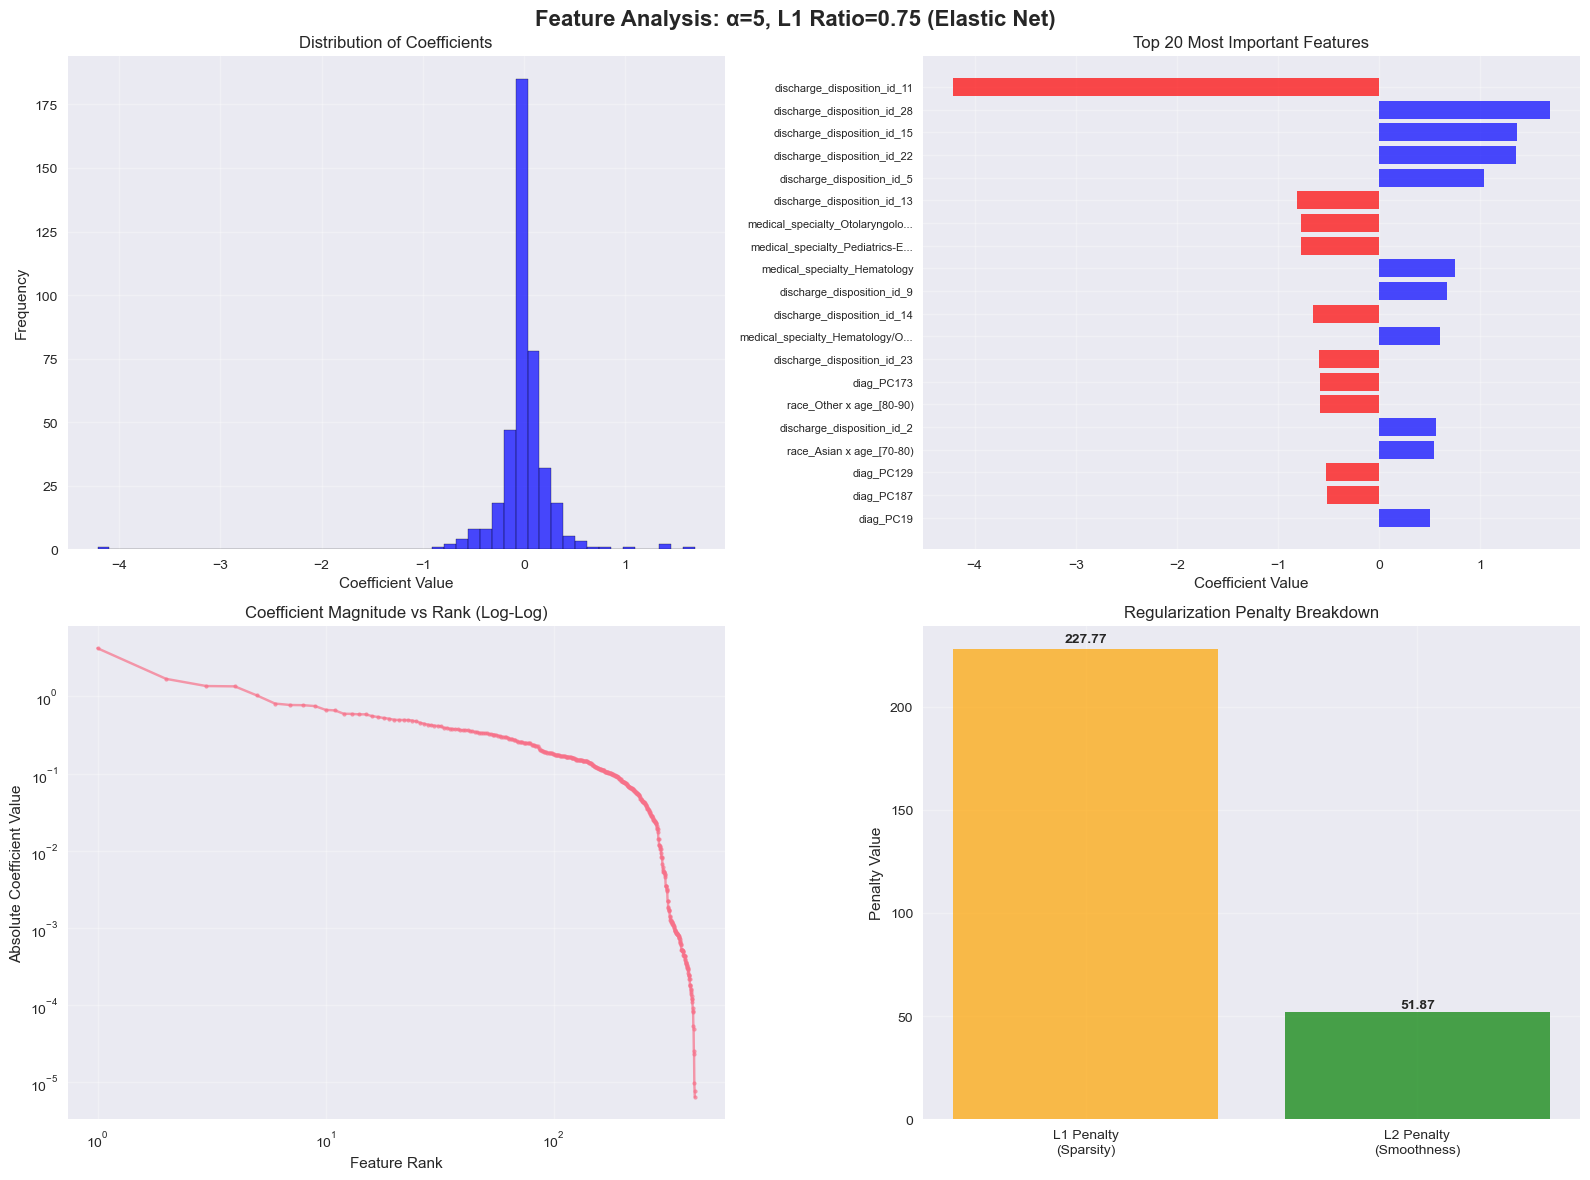

In [9]:
# FEATURE ANALYSIS VISUALIZATIONS
print("=== FEATURE ANALYSIS VISUALIZATIONS ===")

# Create feature analysis plots (removed absolute coefficient plot and pie plot)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Analysis: α=5, L1 Ratio=0.75 (Elastic Net)', fontsize=16, fontweight='bold')

# 1. Coefficient Distribution
ax1 = axes[0, 0]
ax1.hist(feature_analysis_df['coefficient'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Coefficients')
ax1.grid(True, alpha=0.3)

# 2. Top 20 Features Bar Plot (flipped y-axis labels)
ax2 = axes[0, 1]
top_20 = feature_analysis_df.sort_values('abs_coefficient', ascending=False).head(20)
y_pos = np.arange(len(top_20))
colors = ['red' if x < 0 else 'blue' for x in top_20['coefficient']]
ax2.barh(y_pos, top_20['coefficient'], color=colors, alpha=0.7)
ax2.set_yticks(y_pos)
# Flip y-axis labels to read top to bottom
ax2.set_yticklabels([name[:30] + '...' if len(name) > 30 else name for name in top_20['feature_name']], fontsize=8)
ax2.invert_yaxis()  # This flips the y-axis so labels read top to bottom
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top 20 Most Important Features')
ax2.grid(True, alpha=0.3)

# 3. Coefficient Magnitude vs Rank
ax3 = axes[1, 0]
sorted_features = feature_analysis_df.sort_values('abs_coefficient', ascending=False)
ranks = np.arange(1, len(sorted_features) + 1)
ax3.loglog(ranks, sorted_features['abs_coefficient'], 'o-', markersize=3, alpha=0.7)
ax3.set_xlabel('Feature Rank')
ax3.set_ylabel('Absolute Coefficient Value')
ax3.set_title('Coefficient Magnitude vs Rank (Log-Log)')
ax3.grid(True, alpha=0.3)

# 4. Regularization Penalty Breakdown
ax4 = axes[1, 1]
l1_penalty = alpha * l1_ratio * np.sum(np.abs(coef))
l2_penalty = alpha * (1 - l1_ratio) * np.sum(coef ** 2)
total_penalty = l1_penalty + l2_penalty

penalty_data = [l1_penalty, l2_penalty]
penalty_labels = ['L1 Penalty\n(Sparsity)', 'L2 Penalty\n(Smoothness)']
colors = ['orange', 'green']

bars = ax4.bar(penalty_labels, penalty_data, color=colors, alpha=0.7)
ax4.set_ylabel('Penalty Value')
ax4.set_title('Regularization Penalty Breakdown')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, penalty_data):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
print(f"📊 FEATURE ANALYSIS: PSEUDO R-SQUARED AND BINARY CLASSIFICATION METRICS")
print("=" * 70)

# Calculate pseudo R-squared and binary metrics for each feature individually
feature_pseudo_r2_scores = []
feature_auc_scores = []
feature_accuracy_scores = []
feature_log_loss_scores = []

print("🔍 Calculating individual feature pseudo R-squared and binary classification metrics...")

for i, feature_name in enumerate(feature_names):
    # Extract single feature
    X_single = train_X[:, i:i+1]  # Keep 2D shape
    
    # Fit logistic regression for this single feature
    lr = LogisticRegression(random_state=seed, max_iter=1000, class_weight='balanced')
    lr.fit(X_single, train_y)
    
    # Predict probabilities on training set
    y_pred_proba = lr.predict_proba(X_single)[:, 1]
    y_pred = lr.predict(X_single)
    
    # Calculate sample weights for balanced class weight
    classes = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=classes, y=train_y)
    weight_dict = dict(zip(classes, class_weights))
    sample_weights = np.array([weight_dict[label] for label in train_y])
    
    # Calculate pseudo R-squared (McFadden's)
    # Pseudo R² = 1 - (log-likelihood of model / log-likelihood of null model)
    log_likelihood_model = log_loss(train_y, y_pred_proba, normalize=False, sample_weight=sample_weights)
    # Null model: just predict the mean
    mean_prob = np.mean(train_y)
    null_probs = np.full_like(train_y, mean_prob, dtype=float)
    log_likelihood_null = log_loss(train_y, null_probs, normalize=False, sample_weight=sample_weights)
    
    pseudo_r2 = 1 - (log_likelihood_model / log_likelihood_null) if log_likelihood_null != 0 else 0
    feature_pseudo_r2_scores.append(pseudo_r2)
    
    # Calculate AUC
    try:
        auc = roc_auc_score(train_y, y_pred_proba)
        feature_auc_scores.append(auc)
    except:
        feature_auc_scores.append(0.5)  # Random classifier
    
    # Calculate accuracy
    accuracy = accuracy_score(train_y, y_pred)
    feature_accuracy_scores.append(accuracy)
    
    # Calculate log loss
    log_loss_score = log_loss(train_y, y_pred_proba, sample_weight=sample_weights)
    feature_log_loss_scores.append(log_loss_score)

# Add binary classification metrics to feature analysis dataframe
feature_analysis_df['pseudo_r2'] = feature_pseudo_r2_scores
feature_analysis_df['individual_auc'] = feature_auc_scores
feature_analysis_df['individual_accuracy'] = feature_accuracy_scores
feature_analysis_df['individual_log_loss'] = feature_log_loss_scores

# Sort by pseudo R-squared (descending)
pseudo_r2_sorted = feature_analysis_df.sort_values('pseudo_r2', ascending=False)

print(f"\n🏆 TOP 15 FEATURES BY PSEUDO R-SQUARED (HIGHEST EXPLANATORY POWER):")
print(f"{'Rank':<4} {'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'Accuracy':<10} {'Coefficient':<12}")
print("-" * 100)

for i, (idx, row) in enumerate(pseudo_r2_sorted.head(15).iterrows()):
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['individual_accuracy']:8.4f}   {row['coefficient']:10.4f}")

print(f"\n🔻 BOTTOM 15 FEATURES BY PSEUDO R-SQUARED (LOWEST EXPLANATORY POWER):")
print(f"{'Rank':<4} {'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'Accuracy':<10} {'Coefficient':<12}")
print("-" * 100)

for i, (idx, row) in enumerate(pseudo_r2_sorted.tail(15).iterrows()):
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['individual_accuracy']:8.4f}   {row['coefficient']:10.4f}")

# Also show top features by individual AUC
auc_sorted = feature_analysis_df.sort_values('individual_auc', ascending=False)
print(f"\n🎯 TOP 15 FEATURES BY INDIVIDUAL AUC (HIGHEST DISCRIMINATIVE POWER):")
print(f"{'Rank':<4} {'Feature':<50} {'AUC':<8} {'Pseudo R²':<10} {'Accuracy':<10} {'Coefficient':<12}")
print("-" * 100)

for i, (idx, row) in enumerate(auc_sorted.head(15).iterrows()):
    print(f"{i+1:2d}.  {row['feature_name']:48s} {row['individual_auc']:6.4f}   {row['pseudo_r2']:8.4f}   {row['individual_accuracy']:8.4f}   {row['coefficient']:10.4f}")

# Calculate cumulative pseudo R-squared for top features
print(f"\n📈 CUMULATIVE PSEUDO R-SQUARED ANALYSIS:")
print(f"{'Top N Features':<15} {'Cumulative Pseudo R²':<20} {'% of Total Pseudo R²':<20}")
print("-" * 85)

total_pseudo_r2 = sum(feature_pseudo_r2_scores)
for n in [10, 20, 50, 100, 200, len(feature_names)]:
    if n <= len(pseudo_r2_sorted):
        top_n_pseudo_r2 = pseudo_r2_sorted.head(n)['pseudo_r2'].sum()
        percentage = (top_n_pseudo_r2 / total_pseudo_r2) * 100 if total_pseudo_r2 > 0 else 0
        avg_pseudo_r2 = top_n_pseudo_r2 / n if n > 0 else 0
        print(f"{n:<15}  {top_n_pseudo_r2:<20.4f}  {percentage:<20.1f}%")

# Correlation analysis between different metrics
pseudo_r2_coef_corr = np.corrcoef(feature_analysis_df['pseudo_r2'], np.abs(feature_analysis_df['coefficient']))[0, 1]
pseudo_r2_auc_corr = np.corrcoef(feature_analysis_df['pseudo_r2'], feature_analysis_df['individual_auc'])[0, 1]
auc_coef_corr = np.corrcoef(feature_analysis_df['individual_auc'], np.abs(feature_analysis_df['coefficient']))[0, 1]

print(f"\n🔗 CORRELATION ANALYSIS:")
print(f"Pseudo R² vs |Coefficient| correlation: {pseudo_r2_coef_corr:.4f}")
print(f"Pseudo R² vs Individual AUC correlation: {pseudo_r2_auc_corr:.4f}")
print(f"Individual AUC vs |Coefficient| correlation: {auc_coef_corr:.4f}")

# Summary statistics
print(f"\n📊 PSEUDO R-SQUARED SUMMARY STATISTICS:")
print(f"Mean Pseudo R²: {np.mean(feature_pseudo_r2_scores):.6f}")
print(f"Median Pseudo R²: {np.median(feature_pseudo_r2_scores):.6f}")
print(f"Max Pseudo R²: {np.max(feature_pseudo_r2_scores):.6f}")
print(f"Min Pseudo R²: {np.min(feature_pseudo_r2_scores):.6f}")
print(f"Std Pseudo R²: {np.std(feature_pseudo_r2_scores):.6f}")

print(f"\n📊 INDIVIDUAL AUC SUMMARY STATISTICS:")
print(f"Mean Individual AUC: {np.mean(feature_auc_scores):.6f}")
print(f"Median Individual AUC: {np.median(feature_auc_scores):.6f}")
print(f"Max Individual AUC: {np.max(feature_auc_scores):.6f}")
print(f"Min Individual AUC: {np.min(feature_auc_scores):.6f}")
print(f"Std Individual AUC: {np.std(feature_auc_scores):.6f}")

# Features with high pseudo R² but low coefficient magnitude (potential issues)
high_pseudo_r2_low_coef = feature_analysis_df[
    (feature_analysis_df['pseudo_r2'] > np.percentile(feature_pseudo_r2_scores, 75)) & 
    (feature_analysis_df['abs_coefficient'] < np.percentile(feature_analysis_df['abs_coefficient'], 25))
]

print(f"\n⚠️  FEATURES WITH HIGH PSEUDO R² BUT LOW COEFFICIENT MAGNITUDE:")
print(f"   (Potential multicollinearity or scaling issues)")
print(f"   Found {len(high_pseudo_r2_low_coef)} such features")

if len(high_pseudo_r2_low_coef) > 0:
    print(f"{'Feature':<50} {'Pseudo R²':<10} {'AUC':<8} {'|Coeff|':<10}")
    print("-" * 85)
    for _, row in high_pseudo_r2_low_coef.head(10).iterrows():
        print(f"{row['feature_name']:48s} {row['pseudo_r2']:8.4f}   {row['individual_auc']:6.4f}   {row['abs_coefficient']:8.4f}")

# Features with high individual AUC but low coefficient magnitude
high_auc_low_coef = feature_analysis_df[
    (feature_analysis_df['individual_auc'] > np.percentile(feature_auc_scores, 75)) & 
    (feature_analysis_df['abs_coefficient'] < np.percentile(feature_analysis_df['abs_coefficient'], 25))
]

print(f"\n⚠️  FEATURES WITH HIGH INDIVIDUAL AUC BUT LOW COEFFICIENT MAGNITUDE:")
print(f"   (Potential multicollinearity or scaling issues)")
print(f"   Found {len(high_auc_low_coef)} such features")

if len(high_auc_low_coef) > 0:
    print(f"{'Feature':<50} {'AUC':<8} {'Pseudo R²':<10} {'|Coeff|':<10}")
    print("-" * 85)
    for _, row in high_auc_low_coef.head(10).iterrows():
        print(f"{row['feature_name']:48s} {row['individual_auc']:6.4f}   {row['pseudo_r2']:8.4f}   {row['abs_coefficient']:8.4f}")

# Save enhanced feature analysis
feature_analysis_df.to_csv('data/feature_analysis_with_binary_metrics_alpha5_l1ratio0.75.csv', index=False)
print(f"\n✅ Enhanced feature analysis with binary classification metrics saved to 'feature_analysis_with_binary_metrics_alpha5_l1ratio0.75.csv'")

print(f"\n💡 INTERPRETATION:")
print(f"   - Pseudo R² (McFadden's) measures goodness of fit for binary classification")
print(f"   - Individual AUC measures discriminative power of each feature alone")
print(f"   - High pseudo R² features have strong individual explanatory power")
print(f"   - High individual AUC features can distinguish between classes well")
print(f"   - Features with high metrics but low coefficients may indicate multicollinearity")
print(f"   - For binary outcomes, these metrics are more appropriate than regular R²")

📊 FEATURE ANALYSIS: PSEUDO R-SQUARED AND BINARY CLASSIFICATION METRICS
🔍 Calculating individual feature pseudo R-squared and binary classification metrics...

🏆 TOP 15 FEATURES BY PSEUDO R-SQUARED (HIGHEST EXPLANATORY POWER):
Rank Feature                                            Pseudo R²  AUC      Accuracy   Coefficient 
----------------------------------------------------------------------------------------------------
 1.  number_inpatient                                   0.4225   0.6075     0.6655       0.3381
 2.  discharge_disposition_id_11                        0.4067   0.5091     0.1273      -4.2153
 3.  number_emergency                                   0.4054   0.5305     0.8147       0.0794
 4.  discharge_disposition_id_22                        0.4052   0.5165     0.8804       1.3516
 5.  number_diagnoses                                   0.4044   0.5425     0.4435       0.0435
 6.  diag_PC0                                           0.4041   0.5432     0.4900      -0.05

In [11]:
print("=== ORIGINAL FEATURE ANALYSIS ===")

# Add original feature information to the feature analysis dataframe
feature_analysis_df['original_feature'] = feature_analysis_df['feature_name'].map(reverse_map)

# Group by original feature and calculate statistics for both positive and negative coefficients
original_feature_analysis = []

for original_feature in feature_analysis_df['original_feature'].unique():
    original_feature_data = feature_analysis_df[feature_analysis_df['original_feature'] == original_feature]
    
    # Separate positive and negative coefficients
    positive_coefs = original_feature_data[original_feature_data['coefficient'] > 0]['coefficient']
    negative_coefs = original_feature_data[original_feature_data['coefficient'] < 0]['coefficient']
    
    # Calculate statistics
    mean_abs_coef = original_feature_data['abs_coefficient'].mean()
    
    # Positive coefficient statistics
    if len(positive_coefs) > 0:
        mean_positive_coef = positive_coefs.mean()
        max_positive_coef = positive_coefs.max()
    else:
        mean_positive_coef = None
        max_positive_coef = None
    
    # Negative coefficient statistics
    if len(negative_coefs) > 0:
        mean_negative_coef = negative_coefs.mean()
        max_negative_coef = negative_coefs.min()  # Most negative (smallest value)
    else:
        mean_negative_coef = None
        max_negative_coef = None
    
    original_feature_analysis.append({
        'original_feature': original_feature,
        'mean_abs_coef': mean_abs_coef,
        'mean_positive_coef': mean_positive_coef,
        'max_positive_coef': max_positive_coef,
        'mean_negative_coef': mean_negative_coef,
        'max_negative_coef': max_negative_coef,
        'total_features': len(original_feature_data),
        'positive_features': len(positive_coefs),
        'negative_features': len(negative_coefs)
    })

# Convert to DataFrame and sort by mean absolute coefficient
original_feature_analysis_df = pd.DataFrame(original_feature_analysis)
original_feature_analysis_df = original_feature_analysis_df.sort_values('mean_abs_coef', ascending=False)

print(f"\n📊 ANALYSIS SUMMARY:")
print(f"Total original features: {len(original_feature_analysis_df)}")
print(f"Original features with both positive and negative features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] > 0)])}")
print(f"Original features with only positive features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] == 0)])}")
print(f"Original features with only negative features: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] == 0) & (original_feature_analysis_df['negative_features'] > 0)])}")

print(f"\n🏆 RANKED ORIGINAL FEATURES BY MEAN ABSOLUTE COEFFICIENT:")
print(f"{'Rank':<4} {'Original Feature':<35} {'Max Pos':<10} {'Mean Pos':<10} {'Mean Neg':<10} {'Max Neg':<10} {'Features':<8}")
print("-" * 95)
for i, row in original_feature_analysis_df.iterrows():
    print(f"{i+1:2d}.   {row['original_feature']:33s}   {row['max_positive_coef']:8.4f}   {row['mean_positive_coef']:8.4f}"
          f"{row['mean_negative_coef']:8.4f}   {row['max_negative_coef']:8.4f}   {int(row['total_features']):6d}")

# Summary statistics
print(f"\n📈 COMBINED COEFFICIENT STATISTICS:")
print(f"Total features: {len(feature_analysis_df)}")
print(f"Original features with mixed signs: {len(original_feature_analysis_df[(original_feature_analysis_df['positive_features'] > 0) & (original_feature_analysis_df['negative_features'] > 0)])}")
print(f"Average mean absolute coefficient: {original_feature_analysis_df['mean_abs_coef'].mean():.4f}")
print(f"Highest mean absolute coefficient: {original_feature_analysis_df['mean_abs_coef'].max():.4f}")

# Save combined analysis
original_feature_analysis_df.to_csv('data/original_feature_analysis_alpha5_l1ratio0.75.csv', index=False)
print(f"\n✅ Combined original feature analysis completed and saved to 'original_feature_analysis_alpha5_l1ratio0.75.csv'")


=== ORIGINAL FEATURE ANALYSIS ===

📊 ANALYSIS SUMMARY:
Total original features: 30
Original features with both positive and negative features: 11
Original features with only positive features: 10
Original features with only negative features: 9

🏆 RANKED ORIGINAL FEATURES BY MEAN ABSOLUTE COEFFICIENT:
Rank Original Feature                    Max Pos    Mean Pos   Mean Neg   Max Neg    Features
-----------------------------------------------------------------------------------------------
10.   discharge_disposition_id              1.6892     0.5148 -0.7035    -4.2153       25
 7.   number_inpatient                      0.3381     0.3381     nan        nan        1
18.   race x gender                         0.3668     0.2221 -0.1463    -0.1463        4
15.   race                                     nan        nan -0.1331    -0.2970        4
20.   gender x age                          0.1167     0.0666 -0.2582    -0.4750        9
30.   diag                                  0.4991     0.

In [33]:
# Print coefficients for categorical and demographic columns using reverse map
print("Categorical and Demographic Feature Coefficients:")
print("=" * 60)

# Get model coefficients
coef = result['model'].coef_

# Define categorical and demographic features
categorical_features = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty']
demographic_features = ['race', 'gender', 'age']

# Process each original feature
for original_feature in categorical_features + demographic_features:
    print(f"\n🔍 {original_feature.upper()}:")
    print("-" * 40)
    
    # Find all processed features that map back to this original feature
    related_features = [f for f in feature_names if reverse_map.get(f) == original_feature]
    
    if related_features:
        # Get coefficients for these features
        feature_coefs = pd.Series(coef, index=feature_names)[related_features]
        
        # Display with proper formatting
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None, 'display.max_colwidth', None):
            print(feature_coefs)
    else:
        print(f"No processed features found for {original_feature}") 

Categorical and Demographic Feature Coefficients:

🔍 ADMISSION_TYPE_ID:
----------------------------------------
admission_type_id_2    0.014273
admission_type_id_3   -0.035611
admission_type_id_4    0.000807
admission_type_id_5   -0.079038
admission_type_id_6    0.229576
admission_type_id_7    0.000121
admission_type_id_8   -0.000757
dtype: float64

🔍 DISCHARGE_DISPOSITION_ID:
----------------------------------------
discharge_disposition_id_2     0.556056
discharge_disposition_id_3     0.382242
discharge_disposition_id_4     0.179198
discharge_disposition_id_5     1.030752
discharge_disposition_id_6     0.173037
discharge_disposition_id_7     0.262208
discharge_disposition_id_8     0.186721
discharge_disposition_id_9     0.670702
discharge_disposition_id_10   -0.000216
discharge_disposition_id_11   -4.215332
discharge_disposition_id_12    0.043409
discharge_disposition_id_13   -0.809176
discharge_disposition_id_14   -0.659517
discharge_disposition_id_15    1.364386
discharge_disposit

### Error Analysis

In [15]:
dataset = load_data()
data = dataset.data.original

k_fold_split = pickle.load(open('data/k_fold_split.pkl', 'rb'))

In [58]:
print("=== OUTLIER ANALYSIS ===")

# Use the result from the single fold evaluation (from the baseline model above)
test_pred_proba = result['test_decision_score']  # Predicted probabilities from test set
test_y_actual = test_y  # Actual labels from test set

# Map test indices back to original data indices using k-fold split
# k_fold_split[0] contains the test indices for fold 0 (which we used in the baseline)
test_indices_in_original = k_fold_split[0]

# Create analysis dataframe with original indices
outlier_analysis_df = pd.DataFrame({
    'original_index': test_indices_in_original,  # Index in original dataset
    'actual_readmission': test_y_actual,
    'predicted_probability': test_pred_proba,
    'predicted_class': (test_pred_proba > 0.5).astype(int)
})

=== OUTLIER ANALYSIS ===


In [59]:
# Find 15 rows with lowest predicted probability but actually readmitted (class label = 1)
lowest_prob_readmitted = outlier_analysis_df[
    outlier_analysis_df['actual_readmission'] == 1
].sort_values('predicted_probability', ascending=True).head(15)

# Get original data rows for false negatives (lowest prob but readmitted)
false_negatives_data = data.iloc[lowest_prob_readmitted['original_index'].values].copy()
false_negatives_data.insert(0, 'predicted_probability', lowest_prob_readmitted['predicted_probability'].values)

print(f"\n🔍 15 FALSE NEGATIVES (Lowest predicted probability but actually readmitted):")
false_negatives_data


🔍 15 FALSE NEGATIVES (Lowest predicted probability but actually readmitted):


,predicted_probability,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
86028,0.132831,273029700,41354100,Caucasian,Male,[10-20),NaN,1,1,7,5,NaN,NaN,57,1,20,0,0,0,540,250.01,NaN,2,NaN,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
11558,0.172852,47752878,8534772,Caucasian,Female,[10-20),NaN,1,1,7,2,NaN,Pediatrics,70,0,7,0,0,0,250.03,112,493,3,NaN,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30
39024,0.194469,121416774,2188287,Asian,Female,[40-50),NaN,3,1,1,1,NaN,NaN,32,1,12,0,0,0,193,250,401,4,NaN,NaN,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,<30
33116,0.200173,104994114,22236615,Caucasian,Female,[40-50),NaN,6,1,17,4,NaN,Cardiology,65,1,21,0,0,0,278,250,305,3,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,<30
35732,0.200252,110467062,23452101,Caucasian,Female,[40-50),NaN,5,1,17,3,MD,ObstetricsandGynecology,5,4,18,2,1,0,626,285,998,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30
4396,0.200549,24903858,18095193,Caucasian,Female,[50-60),NaN,3,1,4,2,NaN,NaN,24,3,10,0,0,0,414,401,272,5,NaN,>8,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,<30
63654,0.202571,177089076,90040203,Caucasian,Male,[20-30),NaN,2,1,1,4,CP,Emergency/Trauma,57,0,15,0,0,0,682,250.02,493,5,NaN,>8,Steady,No,No,No,Steady,No,No,No,No,No,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
41853,0.204438,129327642,98802900,Caucasian,Female,[30-40),[50-75),2,1,1,5,UN,ObstetricsandGynecology,39,1,6,1,0,0,642,648,250,3,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30
34663,0.206302,108246972,111209265,Caucasian,Female,[70-80),NaN,1,1,7,4,CP,Orthopedics-Reconstructive,39,0,9,0,0,0,805,E888,250,4,NaN,>7,No,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,<30
99654,0.211955,416064362,37482696,Other,Male,[80-90),NaN,2,1,7,2,SP,Emergency/Trauma,29,0,8,0,0,0,8,276,250,7,NaN,NaN,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,<30


In [24]:
# Find 15 rows with highest predicted probability but not readmitted (class label = 0)
highest_prob_not_readmitted = outlier_analysis_df[
    outlier_analysis_df['actual_readmission'] == 0
].sort_values('predicted_probability', ascending=False).head(15)

# Get original data rows for false positives (highest prob but not readmitted)
false_positives_data = data.iloc[highest_prob_not_readmitted['original_index'].values].copy()
false_positives_data.insert(0, 'predicted_probability', highest_prob_not_readmitted['predicted_probability'].values)

print(f"\n🔍 15 FALSE POSITIVES (Highest predicted probability but not readmitted):")
false_positives_data


🔍 15 FALSE POSITIVES (Highest predicted probability but not readmitted):


,predicted_probability,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
89216,0.956821,287830800,88789707,Caucasian,Female,[40-50),NaN,3,22,1,5,MD,InternalMedicine,34,1,17,0,11,6,340,311,304,8,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
38827,0.951861,120715896,24452838,AfricanAmerican,Female,[70-80),NaN,3,22,1,8,MC,Nephrology,29,4,29,1,0,6,440,428,403,8,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
85281,0.947188,269970012,88789707,Caucasian,Female,[40-50),NaN,2,22,7,4,MC,Emergency/Trauma,53,1,16,0,9,6,340,304,250,5,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,>30
62032,0.936466,172851684,88838172,Caucasian,Female,[80-90),NaN,2,22,7,1,MC,Family/GeneralPractice,31,0,17,0,0,7,428,585,250,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
51670,0.932033,153821814,78277599,AfricanAmerican,Female,[50-60),NaN,1,22,7,8,NaN,NaN,58,1,26,1,1,5,250.7,40,707,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
28462,0.926734,93304032,23643405,Caucasian,Female,[20-30),NaN,5,1,17,4,HM,Nephrology,17,1,18,0,3,16,250.81,250.41,583,7,Norm,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
76845,0.926642,232356060,40867677,NaN,Female,[40-50),NaN,1,5,7,2,MC,NaN,35,0,11,0,1,3,276,250.6,250.41,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
87766,0.926048,280905114,41744394,Caucasian,Male,[70-80),NaN,3,22,1,3,MC,Nephrology,40,1,23,1,0,6,457,585,276,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
51937,0.925097,154272774,40786713,Caucasian,Female,[60-70),NaN,3,22,1,8,MC,Family/GeneralPractice,45,1,12,3,2,3,443,707,276,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
61881,0.924618,172576356,25162767,AfricanAmerican,Female,[50-60),NaN,1,22,7,5,MC,InternalMedicine,22,0,19,0,1,5,434,428,250.02,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30


In [57]:
# Analyze false positives: check readmission status for >30 days
print("=== FALSE POSITIVES READMISSION ANALYSIS ===")

# Get the false positives data (highest predicted probability but not readmitted <30)
false_positives_analysis = outlier_analysis_df[(outlier_analysis_df['predicted_class'] == 1) & (outlier_analysis_df['actual_readmission'] == 0)]

# Get original data for false positives to check their actual readmission status
false_positives_original_data = data.iloc[false_positives_analysis['original_index'].values]

# Check readmission status in original data
false_positives_readmission_status = false_positives_original_data['readmitted'].value_counts()

# Calculate proportions
total_false_positives = len(false_positives_analysis)
readmitted_gt30 = false_positives_readmission_status.get('>30', 0)
readmitted_no = false_positives_readmission_status.get('NO', 0)

print(f"\nFalse Positives Breakdown:")
print(f"  Readmitted >30 days: {readmitted_gt30} ({readmitted_gt30/total_false_positives*100:.1f}%)")
print(f"  Not readmitted (NO): {readmitted_no} ({readmitted_no/total_false_positives*100:.1f}%)")

# Get population readmission status
population_readmission_status = data['readmitted'].value_counts()

# Calculate population proportions
pop_readmitted_lt30 = population_readmission_status.get('<30', 0)
pop_readmitted_gt30 = population_readmission_status.get('>30', 0)
pop_not_readmitted = population_readmission_status.get('NO', 0)

# For comparison, we need to condition on not <30 days (i.e., >30 or NO)
pop_not_lt30 = pop_readmitted_gt30 + pop_not_readmitted
pop_gt30_given_not_lt30 = pop_readmitted_gt30 / pop_not_lt30
pop_no_given_not_lt30 = pop_not_readmitted / pop_not_lt30

print(f"\nPopulation Breakdown:")
print(f"  Readmitted <30 days: {pop_readmitted_lt30}")
print(f"  Readmitted >30 days: {pop_readmitted_gt30} ({pop_gt30_given_not_lt30*100:.1f}%)")
print(f"  Not readmitted (NO): {pop_not_readmitted} ({pop_no_given_not_lt30*100:.1f}%)")

# Calculate percentage difference (conditioning on not <30 days)
fp_gt30_pct = readmitted_gt30/total_false_positives
fp_no_pct = readmitted_no/total_false_positives

gt30_diff_pct = (fp_gt30_pct - pop_gt30_given_not_lt30) * 100
no_diff_pct = (fp_no_pct - pop_no_given_not_lt30) * 100

print(f"\nPercentage Difference (False Positives - Population):")
print(f"  >30 days readmission: {gt30_diff_pct:+.1f} percentage points")
print(f"  No readmission: {no_diff_pct:+.1f} percentage points")

=== FALSE POSITIVES READMISSION ANALYSIS ===

False Positives Breakdown:
  Readmitted >30 days: 3177 (52.8%)
  Not readmitted (NO): 2843 (47.2%)

Population Breakdown:
  Readmitted <30 days: 11357
  Readmitted >30 days: 35545 (39.3%)
  Not readmitted (NO): 54864 (60.7%)

Percentage Difference (False Positives - Population):
  >30 days readmission: +13.5 percentage points
  No readmission: -13.5 percentage points


In [56]:
print(f"\n=== FALSE POSITIVES SPLIT BY PROBABILITY ===")

# Get the median probability of false positives
median_prob = false_positives_analysis['predicted_probability'].median()
print(f"Median predicted probability of false positives: {median_prob:.3f}")

# Split into high and low probability groups
high_prob_fp = false_positives_analysis[false_positives_analysis['predicted_probability'] >= median_prob]
low_prob_fp = false_positives_analysis[false_positives_analysis['predicted_probability'] < median_prob]

# Get original data for each group
high_prob_original = data.iloc[high_prob_fp['original_index'].values]
low_prob_original = data.iloc[low_prob_fp['original_index'].values]


high_prob_readmission = high_prob_original['readmitted'].value_counts()
high_prob_gt30 = high_prob_readmission.get('>30', 0)
high_prob_no = high_prob_readmission.get('NO', 0)
high_prob_total = len(high_prob_fp)

print(f"\nHigh Probability Breakdown:")
print(f"  >30 days: {high_prob_gt30} ({high_prob_gt30/high_prob_total*100:.1f}%)")
print(f"  No readmission: {high_prob_no} ({high_prob_no/high_prob_total*100:.1f}%)")

low_prob_readmission = low_prob_original['readmitted'].value_counts()
low_prob_gt30 = low_prob_readmission.get('>30', 0)
low_prob_no = low_prob_readmission.get('NO', 0)
low_prob_total = len(low_prob_fp)

print(f"\nLow Probability Breakdown:")
print(f"  >30 days: {low_prob_gt30} ({low_prob_gt30/low_prob_total*100:.1f}%)")
print(f"  No readmission: {low_prob_no} ({low_prob_no/low_prob_total*100:.1f}%)")

# Calculate difference
gt30_diff = (high_prob_gt30/high_prob_total) - (low_prob_gt30/low_prob_total)
no_diff = (high_prob_no/high_prob_total) - (low_prob_no/low_prob_total)

print(f"\nDifference (High - Low):")
print(f"  >30 days: {gt30_diff*100:+.1f} percentage points")
print(f"  No readmission: {no_diff*100:+.1f} percentage points")


=== FALSE POSITIVES SPLIT BY PROBABILITY ===
Median predicted probability of false positives: 0.599

High Probability Breakdown:
  >30 days: 1700 (56.5%)
  No readmission: 1310 (43.5%)

Low Probability Breakdown:
  >30 days: 1477 (49.1%)
  No readmission: 1533 (50.9%)

Difference (High - Low):
  >30 days: +7.4 percentage points
  No readmission: -7.4 percentage points
